In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import os
import gc
import time
import warnings
from warnings import simplefilter
from itertools import combinations

import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from catboost import EFeaturesSelectionAlgorithm, EShapCalcType
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237980
Number of Columns:  17


In [5]:
train = train.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
train.reset_index(drop=True, inplace=True)

num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237892
Number of Columns:  17


Regression without extra features

In [6]:
columns_to_drop = ['row_id', 'far_price', 'near_price']
plain_train = train.drop(columns_to_drop, axis=1)
plain_train = plain_train.dropna()  

X = plain_train.drop('target', axis=1)
y = plain_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plain_train.reset_index(drop=True, inplace=True)

num_rows, num_columns = plain_train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237760
Number of Columns:  14


In [7]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions using Linear Regression
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error for Linear Regression: {mse_linear}')

Mean Squared Error for Linear Regression: 86.26303694130944


In [8]:
# Create a Ridge regression model
alpha = 1.0  # Regularization strength (adjust as needed)
ridge_model = Ridge(alpha=alpha)

# Train the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 87.72122600072295


Additional Features

In [9]:
pos_changes = train['reference_price'].diff().clip(lower=1)
neg_changes = train['reference_price'].diff().clip(upper=1)

train['RSI'] = 1 - (100/(1 + pos_changes/neg_changes))

In [10]:
# Define the window size for the moving average
window_size = 2
# Compute the moving averages for each stock and the 'wap' column
train['SMA'] = train.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=window_size,  min_periods=1).mean())

In [12]:
train["imbalance"] = train.eval("imbalance_buy_sell_flag * imbalance_size")

In [13]:
#⚡Optiver 🚀Robust Best ⚡ Single Model features

train["volume"] = train.eval("ask_size + bid_size")
train["mid_price"] = train.eval("(ask_price + bid_price) / 2")
train["liquidity_imbalance"] = train.eval("(bid_size-ask_size)/(bid_size+ask_size)")
train["matched_imbalance"] = train.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
train["size_imbalance"] = train.eval("bid_size / ask_size")
train["price_spread"] = train["ask_price"] - train["bid_price"]
train['market_urgency'] = train['price_spread'] * train['liquidity_imbalance']

In [14]:
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,SMA,daily_average_wap,imbalance,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,1.0,1.000021,3180602.69,69144.53,0.999919,0.754340,-0.615890,7.141326,0.000214,0.000161
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,1.0,1.000021,-166603.91,23838.13,1.000278,-0.728751,-0.815787,0.156905,0.000764,-0.000557
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,1.0,1.000021,-302879.87,56951.00,0.999850,0.332935,-0.714567,1.998210,0.000895,0.000298
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,1.0,1.000021,-11917682.27,481357.30,1.000107,-0.990340,-0.213547,0.004853,0.000215,-0.000213
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.0,1.000021,-447549.96,16919.64,0.999705,0.948687,-0.951109,37.976365,0.000622,0.000590


In [15]:
train.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,SMA,daily_average_wap,imbalance,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
5237887,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,1.000343,0.999562,-2440722.89,352119.44,1.000376,-0.816784,-0.841104,0.100847,0.000117,-0.000096
5237888,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,1.000817,0.999562,-349510.47,298501.47,1.000771,0.374254,-0.926706,2.196184,0.000257,0.000096
5237889,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,...,0.995892,0.999562,0.00,196828.98,0.995836,-0.829388,-1.000000,0.093262,0.000094,-0.000078
5237890,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,...,0.999018,0.999562,1000898.84,795524.72,0.999090,-0.684154,-0.979099,0.187540,0.000240,-0.000164
5237891,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,...,1.002134,0.999562,-1884285.71,550249.00,1.002288,-0.091024,-0.854820,0.833139,0.000318,-0.000029


Setting up training and testing data

In [16]:
columns_to_drop = ['row_id', 'far_price', 'near_price', 'imbalance_size', 'imbalance_buy_sell_flag']
train = train.drop(columns_to_drop, axis=1)
train = train.dropna()  

X = train.drop('target', axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train.reset_index(drop=True, inplace=True)

num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237627
Number of Columns:  23


In [17]:
train.head()

,stock_id,date_id,seconds_in_bucket,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,...,SMA,daily_average_wap,imbalance,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,1,0,0,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,...,1.0,1.000021,-166603.91,23838.13,1.000278,-0.728751,-0.815787,0.156905,0.000764,-0.000557
1,2,0,0,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,...,1.0,1.000021,-302879.87,56951.00,0.999850,0.332935,-0.714567,1.998210,0.000895,0.000298
2,3,0,0,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,...,1.0,1.000021,-11917682.27,481357.30,1.000107,-0.990340,-0.213547,0.004853,0.000215,-0.000213
3,4,0,0,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,...,1.0,1.000021,-447549.96,16919.64,0.999705,0.948687,-0.951109,37.976365,0.000622,0.000590
4,5,0,0,1.000635,13552875.92,0.999779,1962.72,1.000635,5647.65,1.0,...,1.0,1.000021,0.00,7610.37,1.000207,-0.484199,-1.000000,0.347529,0.000856,-0.000414


Linear Regression Error for comparison

In [18]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions using Linear Regression
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error for Linear Regression: {mse_linear}')

Mean Squared Error for Linear Regression: 87.57613904947499


In [19]:
# Create a Ridge regression model
alpha = 1.0  # Regularization strength (adjust as needed)
ridge_model = Ridge(alpha=alpha)

# Train the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 88.0158317660386


Catboost fitting

In [20]:
catboost_model = CatBoostRegressor(iterations=200, depth=10, learning_rate=0.05, loss_function='RMSE', random_seed=42)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 9.4359899	test: 9.4651304	best: 9.4651304 (0)	total: 886ms	remaining: 2m 56s
10:	learn: 9.3656375	test: 9.3966373	best: 9.3966373 (10)	total: 8.04s	remaining: 2m 18s
20:	learn: 9.3312716	test: 9.3652191	best: 9.3652191 (20)	total: 16.2s	remaining: 2m 18s
30:	learn: 9.3113747	test: 9.3487414	best: 9.3487414 (30)	total: 24.1s	remaining: 2m 11s
40:	learn: 9.2978230	test: 9.3386347	best: 9.3386347 (40)	total: 31.8s	remaining: 2m 3s
50:	learn: 9.2865997	test: 9.3304166	best: 9.3304166 (50)	total: 39.9s	remaining: 1m 56s
60:	learn: 9.2749190	test: 9.3216937	best: 9.3216937 (60)	total: 47.6s	remaining: 1m 48s
70:	learn: 9.2637699	test: 9.3148822	best: 9.3148822 (70)	total: 55s	remaining: 1m 39s
80:	learn: 9.2546191	test: 9.3085668	best: 9.3085668 (80)	total: 1m 3s	remaining: 1m 33s
90:	learn: 9.2450869	test: 9.3022893	best: 9.3022893 (90)	total: 1m 10s	remaining: 1m 24s
100:	learn: 9.2356872	test: 9.2959884	best: 9.2959884 (100)	total: 1m 18s	remaining: 1m 17s
110:	learn: 9.2269274	

Catboost error

In [21]:
y_pred = catboost_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 85.50285272555007


Column Importance

In [22]:
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                Feature  Importance
21       market_urgency   13.677543
2     seconds_in_bucket   12.983802
14            imbalance   11.149507
20         price_spread    7.740047
18    matched_imbalance    6.961681
13    daily_average_wap    6.789290
4          matched_size    6.652216
5             bid_price    3.776005
7             ask_price    3.368089
1               date_id    3.305754
11                  RSI    2.956045
3       reference_price    2.955247
10              time_id    2.892462
0              stock_id    2.226001
8              ask_size    2.148945
16            mid_price    2.123531
6              bid_size    2.023163
12                  SMA    1.952912
15               volume    1.613878
9                   wap    1.520324
17  liquidity_imbalance    0.619946
19       size_imbalance    0.563609


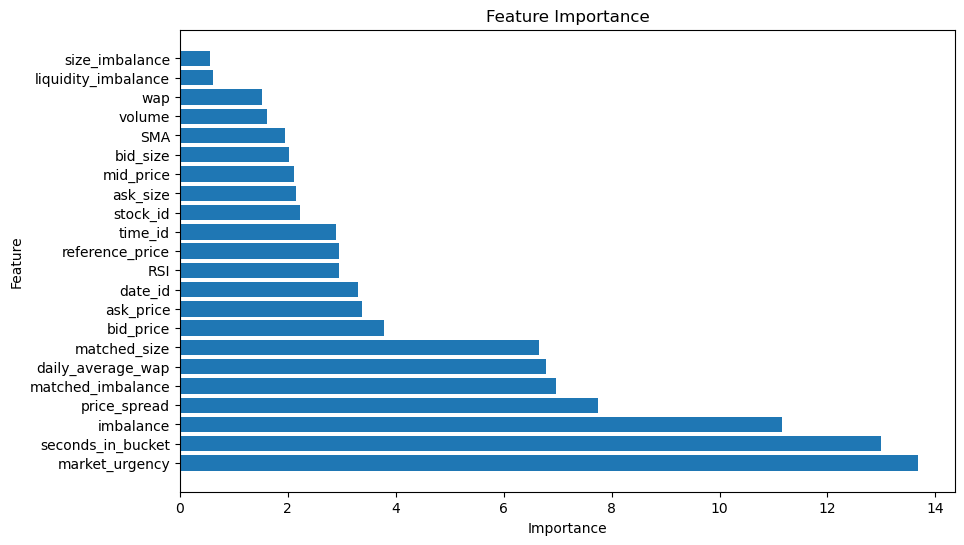

In [23]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Attempting to get SHAP to work

In [ ]:
#columns_to_drop = ['target', 'far_price', 'near_price']
feature_name = train.columns.drop(['target']).tolist()

# Feature selection using SHAP values
# Create Pool object with both features (X) and target variable (y)
train_pool = Pool(X_train, label=y_train)

# Feature selection using SHAP values
summary = ctb_model.select_features(
    train_pool,  # Pass the Pool object that includes both features and target variable
    eval_set=[(X_test, y_test)],
    features_for_select=feature_name,
    num_features_to_select=len(feature_name) - 24,  # Dropping from 124 to 100
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    plot=True,
)